In [1]:
import os
import glob
import json
import cv2
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms as transforms

c:\Users\rainm\miniconda3\envs\pytorch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Input
TRAIN_CSV_RSNA_PATH = "./input/train_rsna.csv"
TRAIN_CSV_INBREAST_PATH = "./input/train_inbreast.xls"
TRAIN_CSV_INBREAST_META_PATH = "./input/train_inbreast_metadata.csv"
TRAIN_CSV_CMMD_PATH = "./input/train_cmmd.csv"

TRAIN_INPUT_IMG_RSNA_PATH = "./images_rsna/"
TRAIN_INPUT_IMG_INBREAST_PATH = "./images_inbreast/"
TRAIN_INPUT_IMG_CMMD_PATH = "./images_cmmd/"

# Output
DATASET_NAME = f"RSNA_CC"
SAVE_FOLDER = f"./output/{DATASET_NAME}"

In [26]:
df_train_rsna = pd.read_csv(TRAIN_CSV_RSNA_PATH)
print("-------------- RSNA -------------")
print(f"Number of images: {len(df_train_rsna)}")
print(f"Number of cancer images: {len(df_train_rsna[(df_train_rsna.cancer == 1)])}")
print(f"Number of cancer CC images: {len(df_train_rsna[((df_train_rsna.cancer == 1) & (df_train_rsna.view == 'CC') & (df_train_rsna.machine_id == 49) & (df_train_rsna.implant== 0) & (df_train_rsna.machine_id == 49) & (df_train_rsna.density != 'D') & (df_train_rsna.density.str.len() > 0))])}")
print(f"Number of implant images: {len(df_train_rsna[(df_train_rsna.implant == 1)])}")
print(f"Number of cancer&implant images: {len(df_train_rsna[((df_train_rsna.implant == 1) & (df_train_rsna.cancer == 1))])}")
df_train_rsna[((df_train_rsna.cancer == 1) & (df_train_rsna.view == 'CC') & (df_train_rsna.machine_id == 49) & (df_train_rsna.implant== 0) & (df_train_rsna.machine_id == 49) & (df_train_rsna.density != 'D') & (df_train_rsna.density.str.len() > 0))].head()

-------------- RSNA -------------
Number of images: 54706
Number of cancer images: 1158
Number of cancer CC images: 294
Number of implant images: 1477
Number of cancer&implant images: 13


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
191,1,10226,530620473,L,CC,71.0,1,1,1,0.0,0,C,49,False
215,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False
1036,1,11094,1417771843,L,CC,74.0,1,1,1,0.0,0,A,49,False


In [4]:
df_train_rsna.iloc[0].density

nan

In [ ]:
df_train_inbreast1 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet1")
df_train_inbreast2 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet2") # Read sheet 2
df_train_inbreast_meta = pd.read_csv(TRAIN_CSV_INBREAST_META_PATH)
print("-------------- INBREAST -------------")
print(f"Number of images: {len(df_train_inbreast2)}")
df_train_inbreast2 = df_train_inbreast2.rename(columns={"Bi-Rads": "birads"})
df_train_inbreast2.drop(df_train_inbreast2[(df_train_inbreast2.birads == 47)].index, inplace=True)
print(df_train_inbreast2.groupby(["birads"]).size())
print(f"Number of cancer images: {len(df_train_inbreast2[(df_train_inbreast2.birads == 5) | (df_train_inbreast2.birads == 6) | (df_train_inbreast2.birads == '4c')])}")
df_train_inbreast = df_train_inbreast2.join(df_train_inbreast1["File Name"], how="right")
df_train_inbreast

In [ ]:
df_train_inbreast_meta.head()

In [ ]:
file_paths = [df_train_inbreast_meta[(df_train_inbreast_meta["Patient ID"] == x)]["File_path"] for x in df_train_inbreast2["Patient ID"].drop_duplicates()]
file_paths_list = []
for i in range(len(df_train_inbreast_meta)):
    file_paths_list.extend(list(map(str, file_paths[i][i][1:-1].split(','))))
file_paths_stripped = []
for path in file_paths_list:
    file_paths_stripped.append(f"{TRAIN_INPUT_IMG_INBREAST_PATH}{path.strip()[1:-1]}")

image_paths_df = pd.DataFrame(file_paths_stripped, columns=["image_path"])
df_train_inbreast = df_train_inbreast.join(image_paths_df, how="right")
df_train_inbreast

In [ ]:
df_train_cmmd = pd.read_csv(TRAIN_CSV_CMMD_PATH)
print("-------------- CMMD -------------")
print(f"Number of images: {len(df_train_cmmd)}")
print(f"Number of cancer images: {len(df_train_cmmd[(df_train_cmmd.Classification == 'Malignant')])}")
df_train_cmmd.head()

In [5]:
# Add file path column to dataframe
df_train_rsna["image_path"] = TRAIN_INPUT_IMG_RSNA_PATH \
                        + df_train_rsna.patient_id.map(str) \
                        + "_" + df_train_rsna.image_id.map(str) \
                        + ".png"
df_train_rsna["image_path"].head()

0     ./images_rsna/10006_462822612.png
1    ./images_rsna/10006_1459541791.png
2    ./images_rsna/10006_1864590858.png
3    ./images_rsna/10006_1874946579.png
4     ./images_rsna/10011_220375232.png
Name: image_path, dtype: object

In [ ]:
df_train_cmmd.Path.str[7:]

In [ ]:
path = df_train_cmmd.Path.map(str)
df_train_cmmd["image_path"] = TRAIN_INPUT_IMG_CMMD_PATH \
                        + df_train_cmmd.Path.str[7:]
df_train_cmmd["image_path"].head()

In [ ]:
df_train_cmmd = df_train_cmmd.rename(columns={"Classification": "cancer", "Age": "age", "LeftRight": "laterality"})
df_train_cmmd["cancer"].replace(["Benign", "Malignant"], [0, 1], inplace=True)
df_train_cmmd.head()

In [ ]:
df_train_inbreast = df_train_inbreast.rename(columns={"birads": "cancer", "Patient age": "age"})
df_train_inbreast["cancer"].replace([1, 2, 3, 4, "4a", "4b", 47, 5, 6, "4c"], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], inplace=True)
print(f"Number of cancer images: {len(df_train_inbreast[(df_train_inbreast.cancer == 1)])}")

In [6]:
def get_laterality(img):
    img2 = img.convert('L')
    img_array = np.asarray(img2)
    img_array_T = np.transpose(img_array)
    if np.sum(img_array_T[0]) < np.sum(img_array_T[-1]):
        laterality = "R"
    else:
        laterality = "L"
    return laterality

In [7]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)

    out = cv2.bitwise_and(img_array, mask)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped = out[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]

    return cropped, mask


In [8]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(2,2))
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [9]:
def truncation_normalization(img, mask):
    mask = cv2.resize(mask, np.array(img).T.shape, interpolation = cv2.INTER_AREA)
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [10]:
def process_image(image_path):
    img = Image.open(image_path)

    cropped, mask = crop(img)
    normalized = truncation_normalization(cropped, mask)
    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    processed_img = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    processed_img_resized = cv2.resize(processed_img, (224, 224), interpolation = cv2.INTER_AREA)

    
    """ laterality = get_laterality(img) 
    if laterality == 'R':
        return cv2.flip(processed_img_resized, 1)
    else:
        return processed_img_resized """
    return processed_img_resized

./images_rsna/10011_220375232.png
(512, 512)


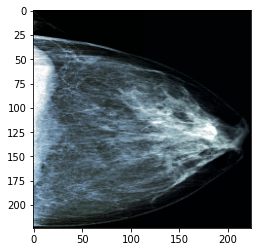

In [11]:
index = 4
print(df_train_rsna['image_path'].iloc[index])
img = Image.open(df_train_rsna['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_rsna['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

In [ ]:
index = 4
print(df_train_cmmd['image_path'].iloc[index])
img = Image.open(df_train_cmmd['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_cmmd['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

In [ ]:
index = 4
print(df_train_inbreast['image_path'].iloc[index])
img = Image.open(df_train_inbreast['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_inbreast['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

## Create Dataset

In [12]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

#df_train_cancer_rsna = df_train_rsna[df_train_rsna.cancer == 1]
#df_train_healthy_rsna = df_train_rsna[(df_train_rsna.cancer == 0)]
df_train_cancer_rsna = df_train_rsna[((df_train_rsna.cancer == 1) & (df_train_rsna.view == 'CC') & (df_train_rsna.machine_id == 49) & (df_train_rsna.implant== 0) & (df_train_rsna.machine_id == 49) & (df_train_rsna.density != 'D') & (df_train_rsna.density.str.len() > 0))]
df_train_healthy_rsna = df_train_rsna[((df_train_rsna.cancer == 0) & (df_train_rsna.view == 'CC') & (df_train_rsna.machine_id == 49) & (df_train_rsna.implant== 0) & (df_train_rsna.machine_id == 49) & (df_train_rsna.density != 'D') & (df_train_rsna.density.str.len() > 0))]

#df_train_cancer = df_train[(df_train.cancer == 1) & (df_train.view == "CC")]
#df_train_healthy = df_train[(df_train.cancer == 0) & (df_train.view == "CC")]
#df_train_implant = df_train_rsna[df_train_rsna.implant == 1]
#df_train_cancer_cmmd = df_train_cmmd[df_train_cmmd.cancer == 1]

#df_train_cancer_inbreast = df_train_inbreast[df_train_inbreast.cancer == 1]

#df_train_healthy_sampled_rsna = df_train_healthy_rsna.sample(n = len(df_train_cancer_rsna) + len(df_train_cancer_cmmd) + len(df_train_cancer_inbreast))
df_train_healthy_sampled_rsna = df_train_healthy_rsna.sample(n = len(df_train_cancer_rsna))
df_train_healthy_unsampled_rsna = pd.concat([df_train_healthy_sampled_rsna, df_train_healthy_rsna]).drop_duplicates(keep=False)

#df_train_subset = pd.concat([df_train_cancer_rsna, df_train_cancer_cmmd, df_train_cancer_inbreast, df_train_healthy_sampled_rsna], ignore_index = True)
df_train_subset = pd.concat([df_train_cancer_rsna, df_train_healthy_sampled_rsna], ignore_index = True)
print(df_train_subset.shape)
df_train_subset.head()

(560, 15)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,./images_rsna/10130_613462606.png
1,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,./images_rsna/10130_1360338805.png
2,1,10226,530620473,L,CC,71.0,1,1,1,0.0,0,C,49,False,./images_rsna/10226_530620473.png
3,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False,./images_rsna/1025_773597682.png
4,1,11094,1417771843,L,CC,74.0,1,1,1,0.0,0,A,49,False,./images_rsna/11094_1417771843.png


## Add new augmentation column to the data (augmented = False) 

In [13]:
df_train_subset = df_train_subset.assign(augmented=0)


In [14]:
df_train_subset.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,augmented
0,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,./images_rsna/10130_613462606.png,0
1,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,./images_rsna/10130_1360338805.png,0
2,1,10226,530620473,L,CC,71.0,1,1,1,0.0,0,C,49,False,./images_rsna/10226_530620473.png,0
3,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False,./images_rsna/1025_773597682.png,0
4,1,11094,1417771843,L,CC,74.0,1,1,1,0.0,0,A,49,False,./images_rsna/11094_1417771843.png,0


## Apply augmentation

In [15]:
h_flip = transforms.Compose( [transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()] )
v_flip = transforms.Compose( [transforms.RandomVerticalFlip(p=1), transforms.ToTensor()] )
rotate15 = transforms.Compose( [transforms.RandomRotation(degrees=(15, 15)), transforms.ToTensor()] )
rotate30 = transforms.Compose( [transforms.RandomRotation(degrees=(30, 30)), transforms.ToTensor()] )
rotate330 = transforms.Compose( [transforms.RandomRotation(degrees=(330, 330)), transforms.ToTensor()] )
rotate345 = transforms.Compose( [transforms.RandomRotation(degrees=(345, 345)), transforms.ToTensor()] )

In [17]:
from torchvision.transforms.functional import to_pil_image

transformations = [
    ('rot15', rotate15),
    ('rot30', rotate30),
    ('rot330', rotate330),
    ('rot345', rotate345),
    ('h_flip', h_flip),
    ('h_flip_rot15', lambda x: rotate15(to_pil_image(h_flip(x)))),
    ('h_flip_rot30', lambda x: rotate30(to_pil_image(h_flip(x)))),
    ('h_flip_rot330', lambda x: rotate330(to_pil_image(h_flip(x)))),
    ('h_flip_rot345', lambda x: rotate345(to_pil_image(h_flip(x)))),
    ('v_flip', v_flip),
    ('v_flip_rot15', lambda x: rotate15(to_pil_image(v_flip(x)))),
    ('v_flip_rot30', lambda x: rotate30(to_pil_image(v_flip(x)))),
    ('v_flip_rot330', lambda x: rotate330(to_pil_image(v_flip(x)))),
    ('v_flip_rot345', lambda x: rotate345(to_pil_image(v_flip(x)))),
    ('h_flip_v_flip', lambda x: v_flip(to_pil_image(h_flip(x)))),
    ('h_flip_v_flip_rot15', lambda x: rotate15(to_pil_image(v_flip(to_pil_image(h_flip(x)))))),
    ('h_flip_v_flip_rot30', lambda x: rotate30(to_pil_image(v_flip(to_pil_image(h_flip(x)))))),
    ('h_flip_v_flip_rot330', lambda x: rotate330(to_pil_image(v_flip(to_pil_image(h_flip(x)))))),
    ('h_flip_v_flip_rot345', lambda x: rotate345(to_pil_image(v_flip(to_pil_image(h_flip(x)))))),
]

for index, row in tqdm(df_train_subset.iterrows()):
    image_path = row['image_path']
    age = row['age']

    image = Image.open(image_path)

    for transform_name, transform_func in transformations:
        transformed_image = transform_func(image)
        transformed_image_pil = transforms.ToPILImage()(transformed_image)  # Convert to PIL image
        transformed_image_path = f"{os.path.splitext(image_path)[0]}_{transform_name}.png"
        transformed_image_pil.save(transformed_image_path)

        df_train_subset = df_train_subset.append({'age': age, 'image_path': transformed_image_path, 'augmented': 1}, ignore_index=True)

0it [00:00, ?it/s]C:\Users\rainm\AppData\Local\Temp\ipykernel_33000\3191427706.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_subset = df_train_subset.append({'age': age, 'image_path': transformed_image_path, 'augmented': 1}, ignore_index=True)
C:\Users\rainm\AppData\Local\Temp\ipykernel_33000\3191427706.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_subset = df_train_subset.append({'age': age, 'image_path': transformed_image_path, 'augmented': 1}, ignore_index=True)
C:\Users\rainm\AppData\Local\Temp\ipykernel_33000\3191427706.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_subset = df_train_subset.append({'age': age, 'image_path': transformed_image_path, 'augmented': 1}, ignore_i

In [19]:
len(df_train_subset)

11200

In [20]:
for image_path in tqdm(df_train_subset["image_path"]):
    patient = image_path.split('/')[-1][:-4]
    processed_img = process_image(image_path)
    cv2.imwrite(f"{SAVE_FOLDER}/{patient}.png", processed_img)

100%|██████████| 11200/11200 [01:59<00:00, 93.77it/s] 


In [21]:
df_train_subset["processed_img_path"] = SAVE_FOLDER + '/' +\
df_train_subset["image_path"].str.extract(r"([ \w-]+\.png)")

df_train_subset.to_csv("./output/df_train_subset_rsna_cc.csv")